In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import time
from utils import *

from rec import Rec
from types import SimpleNamespace   

import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")

%matplotlib inline

## Sizes and propagation settings

In [2]:
n = 2048  # data size in each dimension
npsi = 4096+4096#n+n//4+n//8 # object size in each dimension
pad = n//16 # pad for the reconstructed probe
nq = n+2*pad # probe size
ex = 8 # ex padding for pos_init
npatch = nq+2*ex # patch size for pos_init

z1 = -17.75e-3# [m] position of the sample
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
# adjustments for the cone beam
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = float(cp.abs(detector_pixelsize/magnification))

show = True # do visualization or not at all

path = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01'
path_out = f'/data/vnikitin/ESRF/ID16A/20240924_rec2/SiemensLH/code2um_nfp18x18_01'



## read data

[[2314.72025294 -178.05540407]
 [2314.72025294  178.05540407]
 [2374.07205429  534.16621222]
 [2552.12745836  534.16621222]
 [2552.12745836  890.27702036]
 [2314.72025294 1187.03602715]
 [2433.42385565 1661.850438  ]
 [2492.77565701 2017.96124615]
 [2492.77565701 2017.96124615]
 [2314.72025294 2492.77565701]]
[[2208. -300.]
 [2209.   54.]
 [2232.  492.]
 [2382.  560.]
 [2384.  907.]
 [2210. 1054.]
 [2277. 1654.]
 [2329. 2025.]
 [2329. 2025.]
 [2211. 2350.]]


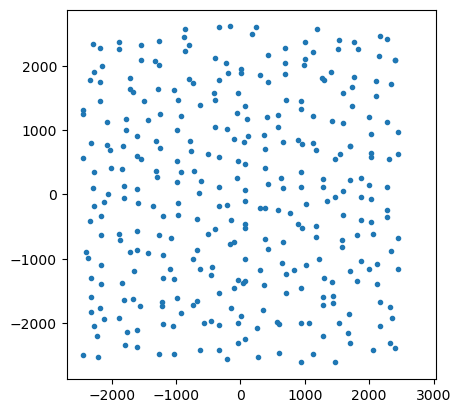

npos=324


In [3]:
import h5py
npos = 18*18
pos_step = 1 # steps in positions
with h5py.File(f'{path}/code2um_nfp18x18_010000.h5') as fid:
    data = fid['/entry_0000/measurement/data'][:npos].astype('float32')
    
with h5py.File(f'{path}/ref_0000.h5') as fid:
    ref = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}/dark_0000.h5') as fid:
    dark = fid['/entry_0000/measurement/data'][:].astype('float32')

pos_init = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[:,::-1]
pos_init = pos_init/voxelsize*(2048//n)*1e-6
pos_init[:,1]*=-1

print(pos_init[-10:])
pos_init = np.load(f'shifts_new.npy')
print(pos_init[-10:])
#centering
pos_init[:,1]-=(np.amax(pos_init[:,1])+np.amin(pos_init[:,1]))/2
pos_init[:,0]-=(np.amax(pos_init[:,0])+np.amin(pos_init[:,0]))/2
pos_init = pos_init.reshape(int(np.sqrt(npos)),int(np.sqrt(npos)),2)
pos_init = pos_init[::pos_step,::pos_step,:].reshape(npos//pos_step**2,2)
data = data.reshape(int(np.sqrt(npos)),int(np.sqrt(npos)),n,n)
data = data[::pos_step,::pos_step,:].reshape(npos//pos_step**2,n,n)

ids = np.where((np.abs(pos_init[:,0])<npsi//2-n//2-pad-ex)*(np.abs(pos_init[:,1])<npsi//2-n//2-pad-ex))[0]#[0:2]
data = data[ids]
pos_init = pos_init[ids]

plt.plot(pos_init[:,0],pos_init[:,1],'.')
plt.axis('square')
plt.show()

npos = len(ids)
print(f'{npos=}')

# chunk = 16
# nchunk = int(np.ceil(npos/chunk))

#data=cp.array(data)
#dark=cp.array(dark)
#ref=cp.array(ref)
#pos_init=cp.array(pos_init)

26
33
35
36
32
37
21
29
30
22
30
24
28
31
29
28
28
24
29
28
34
28
24
19
29
22
35
31
29
30
22
27
32
23
24
27
24
27
27
28
18
25
22
21
25
25
23
29
28
24
29
25
20
26
24
28
27
27
31
23
26
26
25
35
26
29
23
29
23
23
31
30
27
24
28
21
22
20
18
27
25
28
26
30
28
31
22
22
25
25
24
20
31
17
21
25
34
16
30
25
27
23
32
25
22
21
21
23
26
24
30
24
29
30
24
28
25
23
23
29
23
26
24
23
22
24
26
30
24
24
29
28
30
22
25
19
24
21
24
31
24
17
28
28
31
26
25
20
26
24
28
21
29
32
29
24
30
27
24
20
20
17
25
23
21
21
15
23
32
26
27
23
20
27
22
36
18
21
29
27
19
21
16
29
24
25
22
28
24
29
24
29
18
27
30
21
24
26
24
21
21
17
24
33
24
26
22
29
24
35
26
26
21
19
33
26
22
29
23
23
18
30
29
25
18
29
19
20
22
30
22
22
20
22
19
21
25
24
17
31
24
23
25
20
30
24
21
22
27
20
26
24
29
26
25
29
32
21
23
27
28
25
30
29
32
23
27
19
22
26
25
31
29
26
30
16
17
25
25
17
23
20
19
18
30
21
25
28
28
23
25
27
21
24
21
21
16
29
21
22
23
27
29
26
26
17
22
34
20
30
24
30
29
32
25
17
19
24
32
22
23
15
14
28
13


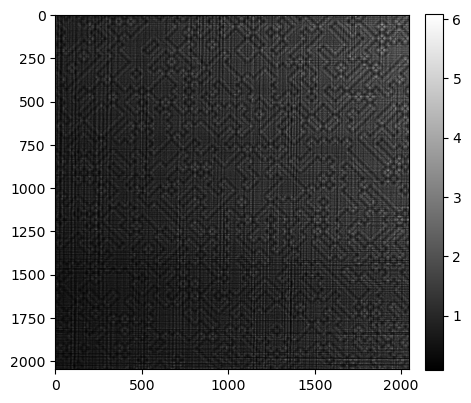

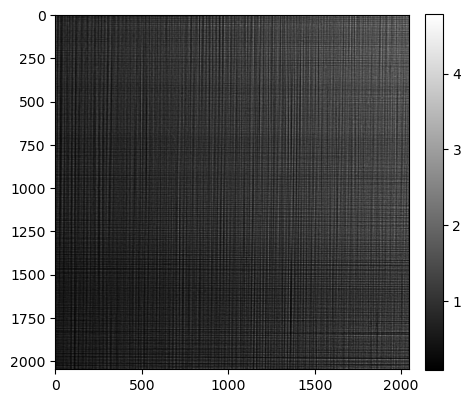

In [4]:
import cupyx.scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    res = data.copy()
    w = [dezinger,dezinger]
    for k in range(data.shape[0]):
        data0 = cp.array(data[k])
        fdata = ndimage.median_filter(data0, w)
        print(np.sum(np.abs(data0-fdata)>fdata*dezinger_threshold))
        res[k] = np.where(np.abs(data0-fdata)>fdata*dezinger_threshold, fdata, data0).get()
    return res

dark = np.mean(dark,axis=0)
ref = np.mean(ref,axis=0)
data -= dark
ref -= dark

data[data<0]=0
ref[ref<0]=0
data[:,1320//3:1320//3+25//3,890//3:890//3+25//3] = data[:,1280//3:1280//3+25//3,890//3:890//3+25//3]
ref[1320//3:1320//3+25//3,890//3:890//3+25//3] = ref[1280//3:1280//3+25//3,890//3:890//3+25//3]

data = remove_outliers(data, 3, 0.8)    
ref = remove_outliers(ref[None], 3, 0.8)[0]

data /= np.mean(ref)
ref /= np.mean(ref)

data[np.isnan(data)] = 1
ref[np.isnan(ref)] = 1

mshow(data[0])
mshow(ref)

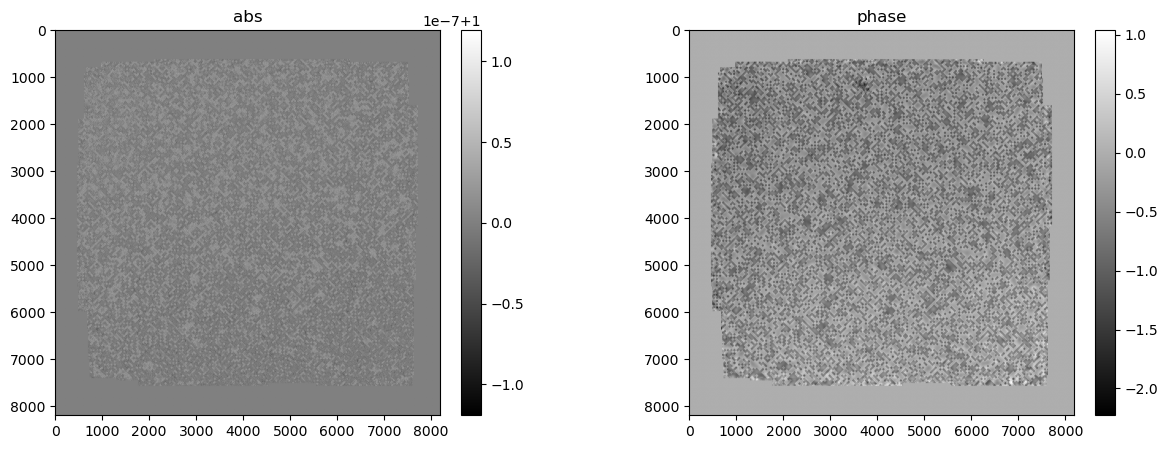

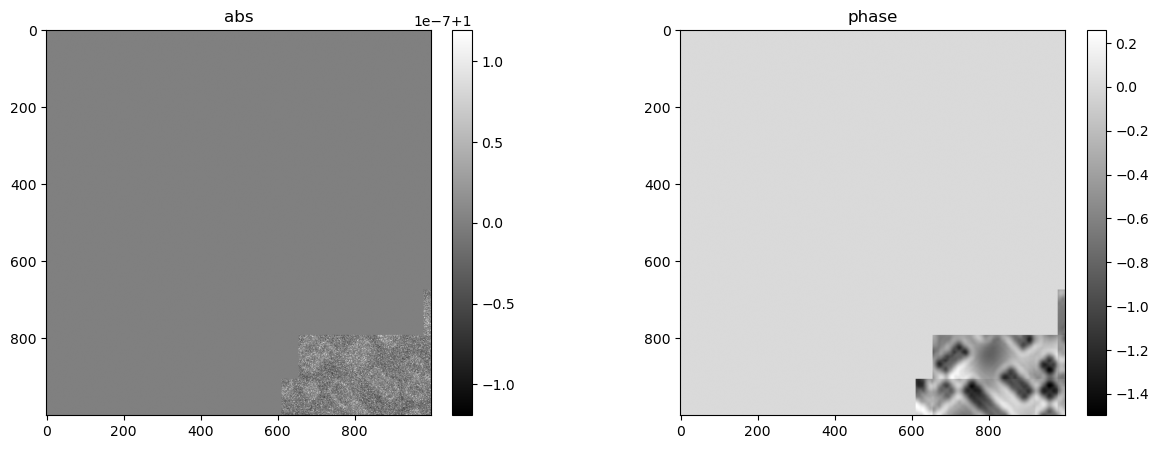

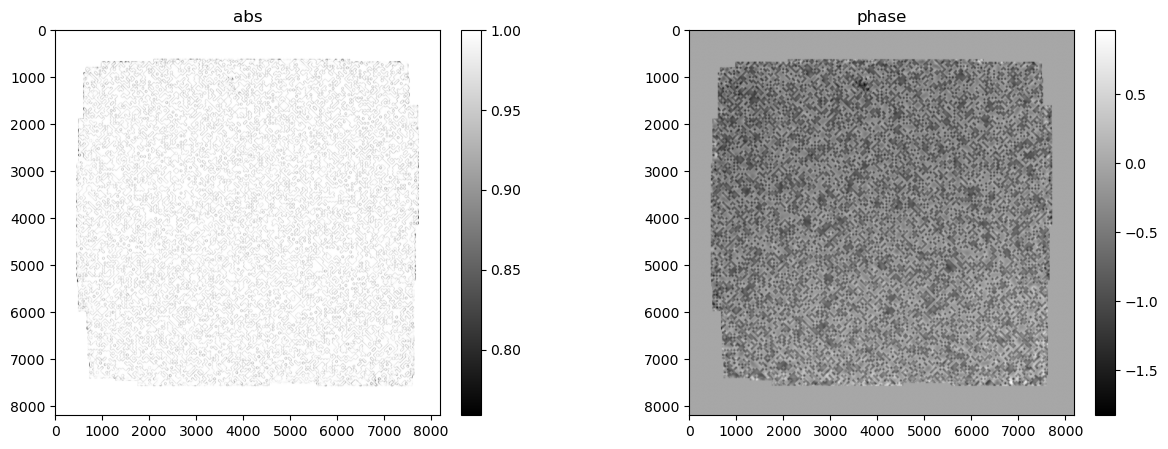

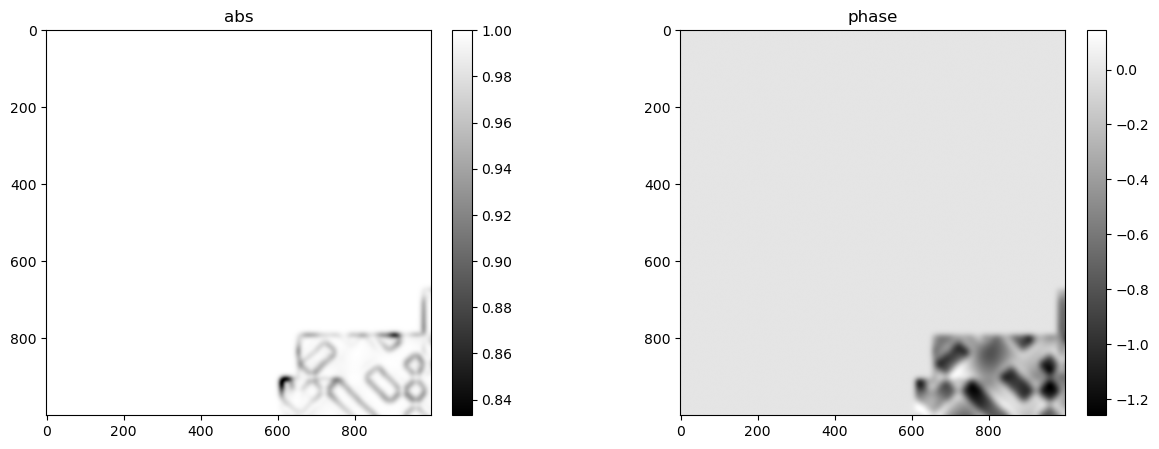

In [5]:
def Paganin(data, wavelength, voxelsize, delta_beta,  alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2+fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    return phase

def rec_init(rdata,ipos_init):
    recMultiPaganin = cp.zeros([npsi,npsi],dtype='float32')
    recMultiPaganinr = cp.zeros([npsi,npsi],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = cp.array(rdata[j])        
        r = Paganin(r, wavelength, voxelsize,  24.05, 1e-1)
        rr = r*0+1 # to compensate for overlap                        
        rpsi = cp.zeros([npsi,npsi],dtype='float32')
        rrpsi = cp.zeros([npsi,npsi],dtype='float32')
        stx = npsi//2-ipos_init[j,1]-n//2
        endx = stx+n
        sty = npsi//2-ipos_init[j,0]-n//2
        endy = sty+n
        rpsi[sty:endy,stx:endx] = r
        rrpsi[sty:endy,stx:endx] = rr
        
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi
        
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1    
    recMultiPaganin /= recMultiPaganinr    
    recMultiPaganin = np.exp(1j*recMultiPaganin)
    return recMultiPaganin

ipos_init = np.round(np.array(pos_init)).astype('int32')
rdata = np.array(data/(ref+1e-5))
psi_init = rec_init(rdata,ipos_init)
mshow_polar(psi_init)
mshow_polar(psi_init[:1000,:1000])

# smooth borders
v = cp.arange(-npsi//2, npsi//2)/npsi
[vx, vy] = cp.meshgrid(v, v)
v = cp.exp(-1000*(vx**2+vy**2)).astype('float32')

psi_init = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(psi_init)))
psi_init = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(psi_init*v))).astype('complex64')
mshow_polar(psi_init)
mshow_polar(psi_init[:1000,:1000])

rdata=v=[]


In [6]:

args = SimpleNamespace()

args.ngpus = 4
args.npsi = npsi
args.nq = nq
args.npatch = npatch
args.n = n
args.npos = npos
args.nchunk = 8
args.pad = pad
args.ex = 8
args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.eps = 1e-8
args.rho = np.array([1,2,0.1])

cl_rec = Rec(args)



#### Initial guess for the probe calculated by backpropagating the square root of the reference image
#### Smooth the probe borders for stability

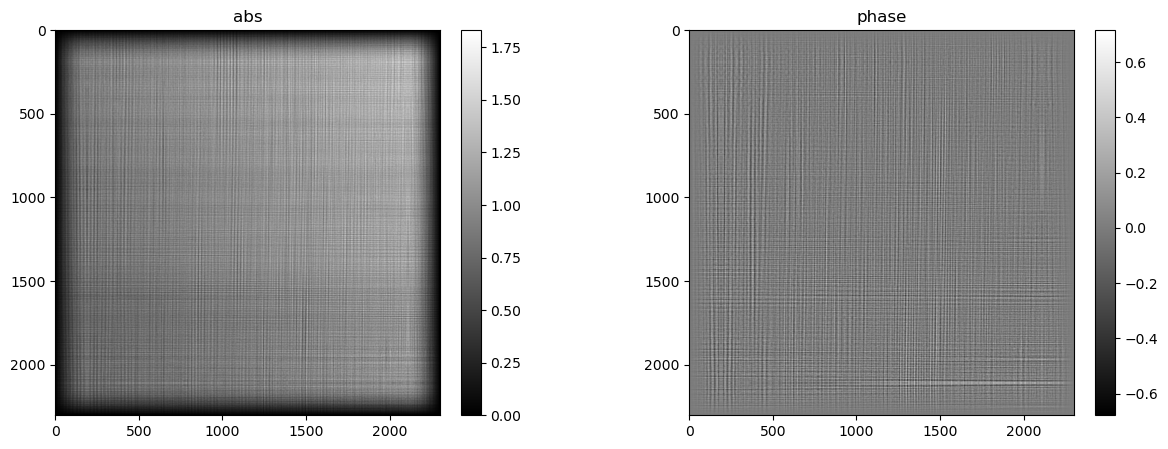

In [7]:
q_init = cp.array(cl_rec.DT(np.sqrt(ref[np.newaxis]))[0])

ppad = 3 * pad // 2
q_init = np.pad(
    q_init[ppad : nq - ppad, ppad : nq - ppad],
    ((ppad, ppad), (ppad, ppad)),
    "symmetric",
)
v = cp.ones(nq, dtype="float32")
vv = cp.sin(cp.linspace(0, cp.pi / 2, ppad))
v[:ppad] = vv
v[nq - ppad :] = vv[::-1]
v = cp.outer(v, v)
q_init = cp.abs(q_init * v) * cp.exp(1j * cp.angle(q_init) * v)

mshow_polar(q_init)

calc_reused 1.5595552921295166
calc_phi 0.8409757614135742
0) err=2.26354e+07
error_debug 0.5508711338043213
grads 1.5669703483581543
alpha 1.2546372413635254
calc_reused 1.4958000183105469
calc_phi 0.8741872310638428
1) err=3.69788e+08
error_debug 0.452681303024292
grads 1.5276601314544678
beta 1.6656453609466553
alpha 1.1831417083740234
calc_reused 1.3803787231445312
calc_phi 0.8804421424865723
2) err=3.65938e+08
error_debug 0.4073915481567383
grads 1.5294480323791504
beta 1.6546144485473633
alpha 1.0726902484893799
calc_reused 1.3773269653320312
calc_phi 0.8544199466705322
3) err=3.64450e+08
error_debug 0.39388418197631836
grads 1.6662001609802246
beta 1.6384921073913574
alpha 1.1720390319824219
calc_reused 1.386411428451538
calc_phi 0.8198432922363281
4) err=3.64133e+08
error_debug 0.43274784088134766
grads 1.590458869934082
beta 1.6349055767059326
alpha 1.114255428314209
calc_reused 1.3746654987335205
calc_phi 0.8567080497741699
5) err=nan
error_debug 0.40847349166870117
grads 1.6

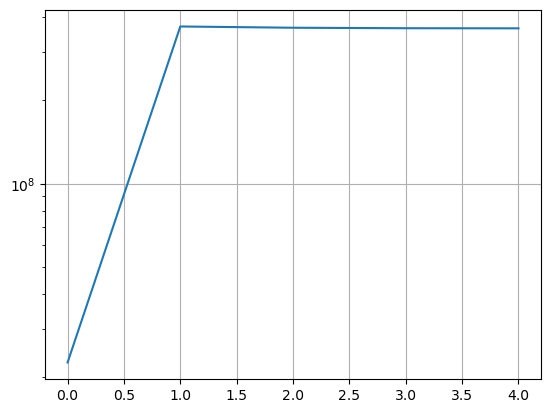

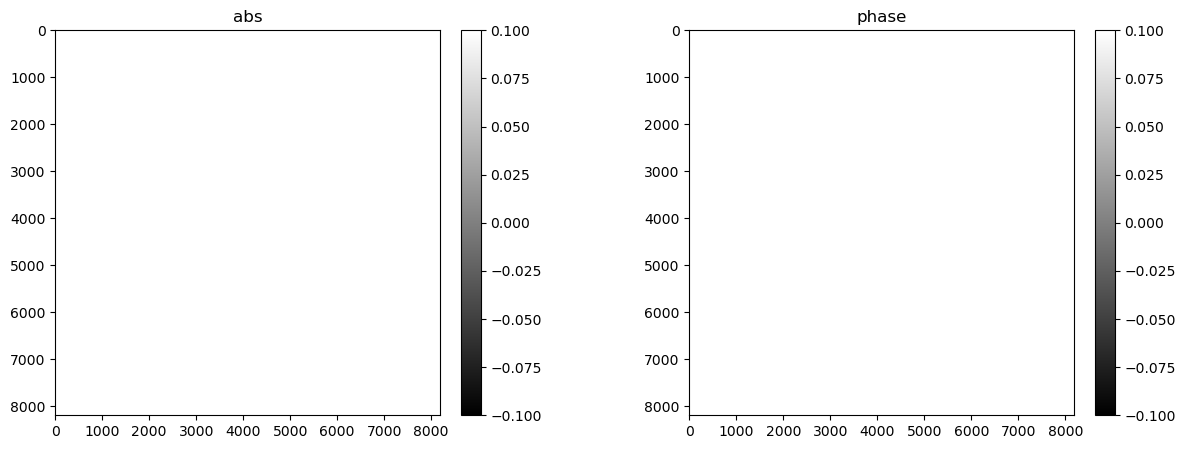

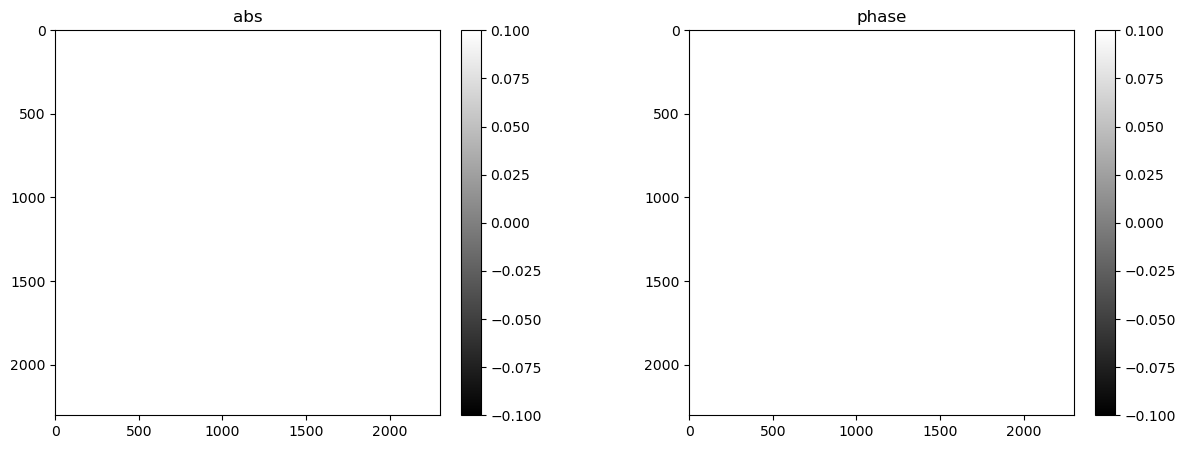

[]

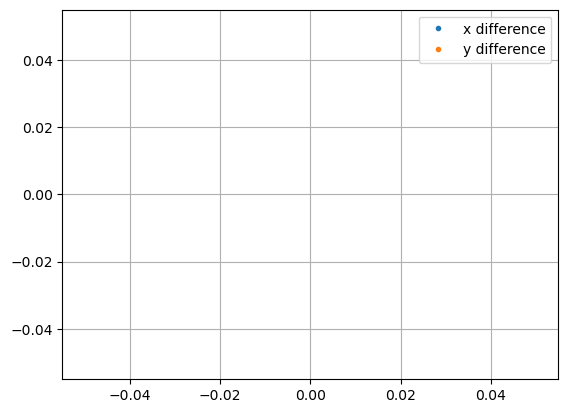

Timer unit: 1e-09 s

Total time: 115.796 s
File: /home/beams8/TOMO/vnikitin/BH-ptychography/rec.py
Function: BH at line 68

Line #      Hits         Time  Per Hit   % Time  Line Contents
    68                                               def BH(self, data, vars, pars):
    69         1 1208129563.0    1e+09      1.0          data = np.sqrt(data)
    70                                           
    71         1       1477.0   1477.0      0.0          alpha = 1
    72         1        718.0    718.0      0.0          rho = pars["rho"]
    73         1        643.0    643.0      0.0          reused = {}
    74                                           
    75        17      25073.0   1474.9      0.0          for i in range(pars["niter"]):
    76                                                       # Calc reused variables and big_phi
    77        16      30037.0   1877.3      0.0              t = time.time()
    78        16        2e+10    1e+09     19.6              self.calc_reused

In [8]:


# parameters
pars = {"niter": 16, "err_step": 1, "vis_step": -1}
pars["rho"] = [1, 2, 0.1]
pars["method"] = "BH-CG"
pars["flg"] = f"{pars['method']}_{pars['rho'][0]}_{pars['rho'][1]}_{pars['rho'][2]}"

# variables
vars = {}
vars["psi"] = cp.array(psi_init).copy()
vars["q"] = cp.array(q_init).copy()
vars["ri"] = np.floor(pos_init).astype("int32")
vars["r"] = np.array(pos_init - np.floor(pos_init).astype("int32")).astype("float32")
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])
# reconstruction
# vars = cl_rec.BH(data, vars, pars)
%load_ext line_profiler
%lprun -f cl_rec.BH vars = cl_rec.BH(data, vars, pars)
# results
erra = vars["table"]["err"].values
plt.plot(erra, label=f"{pars['flg']}")
plt.yscale("log")
plt.grid()
mshow_polar(vars["psi"])
mshow_polar(vars["q"])
pos_rec = vars["ri"] + vars["r"]
plt.plot((pos_init[:, 1] - pos_rec[:, 1]), ".", label="x difference")
plt.plot((pos_init[:, 0] - pos_rec[:, 0]), ".", label="y difference")
plt.legend()
plt.grid()
plt.plot()